In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [28]:
# Load waste data from CSV export
csv_path = Path("reports/waste_log_export.csv")
df = pd.read_csv(csv_path)
df['notes'] = df['notes'].fillna('')
print(f"Loaded {len(df)} entries")
df.head()

Loaded 38 entries


,id,timestamp,station,waste_type,item_name,quantity_type,quantity_value,notes
0,c16bc56a-0317-43cc-8a0d-46da943efeec,2025-12-29T15:36:37.430691,middle,trim,pork rack,lbs,3.75,
1,29b6f813-d3ec-417e-8280-90c0946cb69c,2025-12-29T16:22:32.761043,grill,trim,new york,lbs,4.50,dry aged
2,7982dec0-6236-487f-801a-aa2c7518f309,2025-12-31T13:07:36.190794,grill,trim,Filet,lbs,0.75,
3,c58fdce9-7bc8-429a-9acc-e3c429b6372e,2025-12-31T13:09:04.851538,grill,trim,Ribeye,lbs,2.12,
4,29ea9d5a-ea6e-4059-9f51-4ce3223703c7,2025-12-31T13:10:16.927261,other_prep,spoilage,red pepper,lbs,3.00,


In [29]:
# Quick dat overview
print("Columns:", df.columns.tolist())
print("\nWaste types:", df['waste_type'].unique())
print("Stations:", df['station'].unique())
print("Quantity types:", df['quantity_type'].unique())

Columns: ['id', 'timestamp', 'station', 'waste_type', 'item_name', 'quantity_type', 'quantity_value', 'notes']

Waste types: ['trim' 'spoilage' 'burnt/overcooked' 'overproduction']
Stations: ['middle' 'grill' 'other_prep']
Quantity types: ['lbs' 'po']


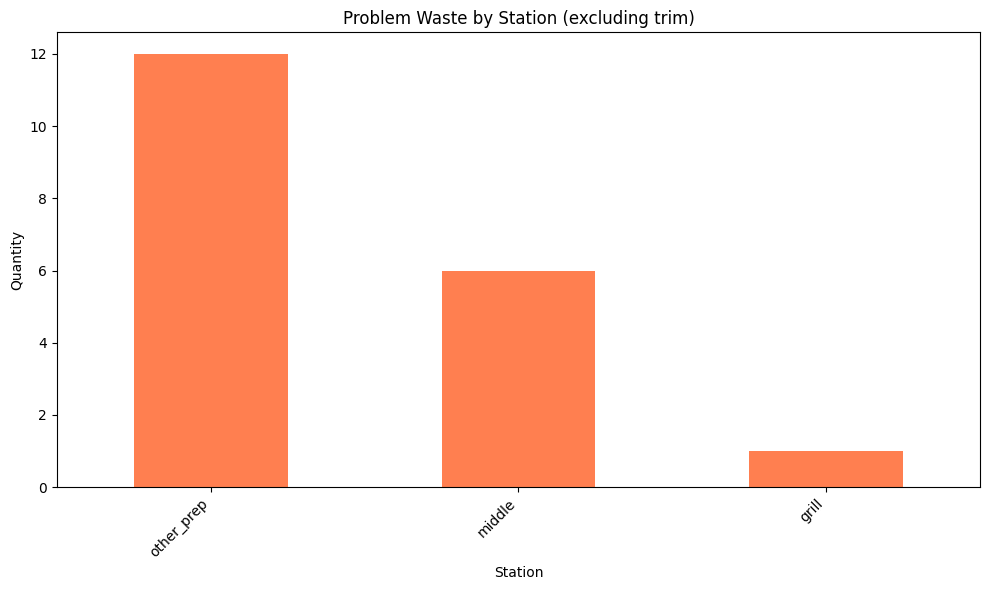

In [30]:
# Filter to problem waste only (exclude trim)
problem_types = ['spoilage', 'overproduction', 'burnt/overcooked']
problem_df = df[df['waste_type'].isin(problem_types)]

# Group by station and sum quantity
station_waste = problem_df.groupby('station')['quantity_value'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
station_waste.plot(kind='bar', color='coral')
plt.title('Problem Waste by Station (excluding trim)')
plt.xlabel('Station')
plt.ylabel('Quantity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

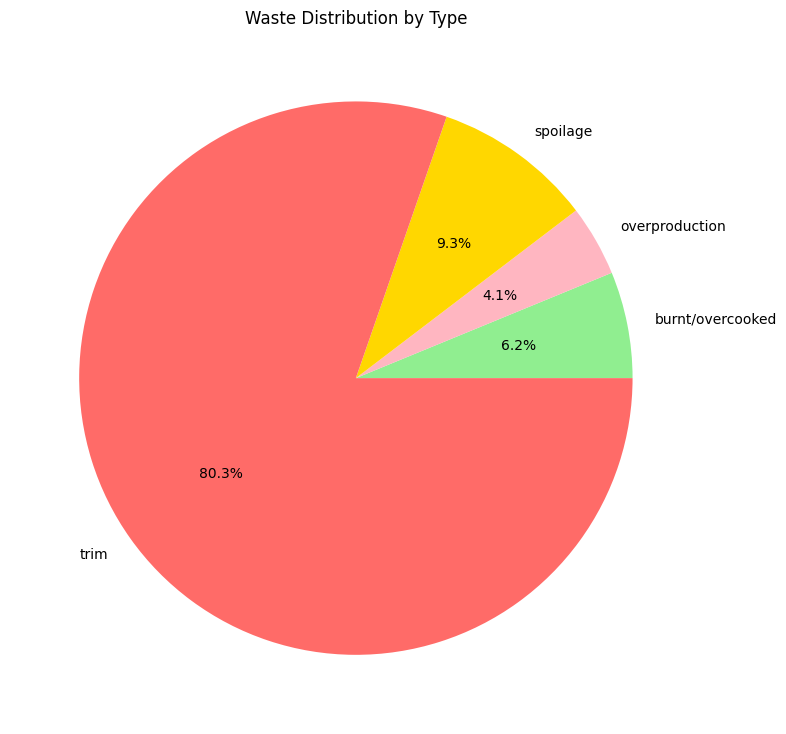

In [31]:
# Waste by type
waste_by_type = df.groupby('waste_type')['quantity_value'].sum()

plt.figure(figsize=(8, 8))
colors = ['#90EE90', '#FFB6C1', '#FFD700', '#FF6b68']
plt.pie(waste_by_type, labels=waste_by_type.index, autopct='%1.1f%%', colors=colors)
plt.title('Waste Distribution by Type')
plt.tight_layout()
plt.show()

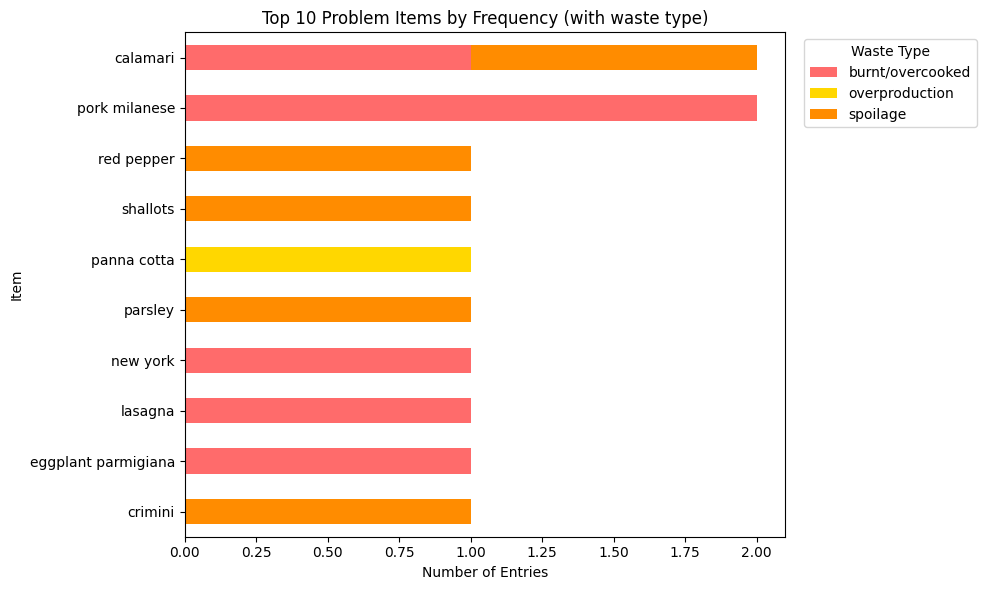

In [32]:
# Top 10 problem items with waste type breakdown
problem_counts = problem_df.groupby(['item_name', 'waste_type']).size().unstack(fill_value=0)

# Sort by total frequency
problem_counts['total'] = problem_counts.sum(axis=1)
problem_counts = problem_counts.sort_values('total', ascending=True).tail(10)
problem_counts = problem_counts.drop('total', axis=1)

# Plot stacked horizontal bar
problem_counts.plot(kind='barh', stacked=True, figsize=(10, 6), 
                    color=['#FF6B6B', '#FFD700', '#FF8C00'])
plt.title('Top 10 Problem Items by Frequency (with waste type)')
plt.xlabel('Number of Entries')
plt.ylabel('Item')
plt.legend(title='Waste Type', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

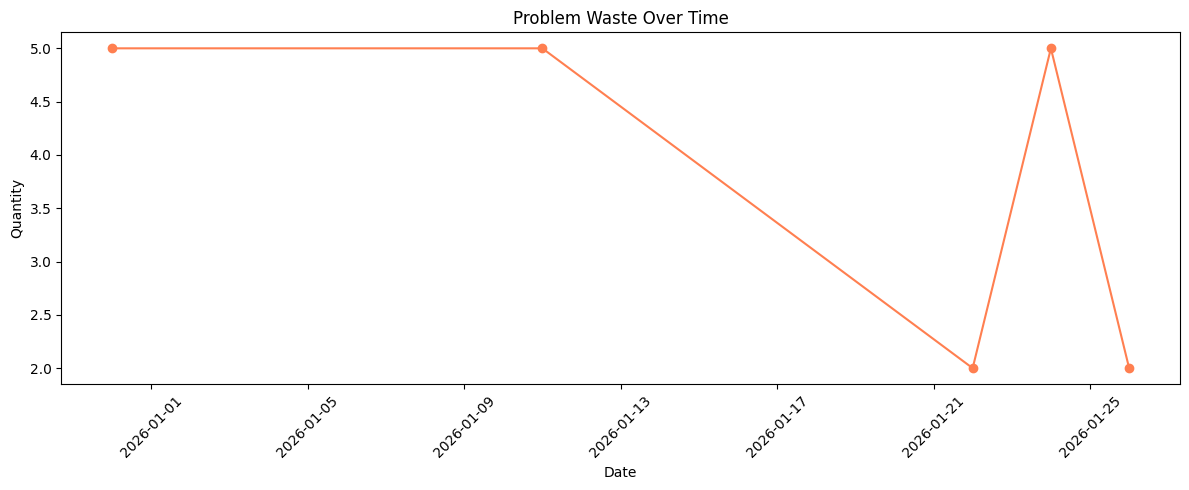

In [33]:
# Convert timestamp to datetime
df['date'] = pd.to_datetime(df['timestamp']).dt.date

# Daily problem waste totals
daily_problem = problem_df.copy()
daily_problem['date'] = pd.to_datetime(daily_problem['timestamp']).dt.date
daily_totals = daily_problem.groupby('date')['quantity_value'].sum()

plt.figure(figsize=(12, 5))
daily_totals.plot(kind='line', marker='o', color='coral')
plt.title('Problem Waste Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

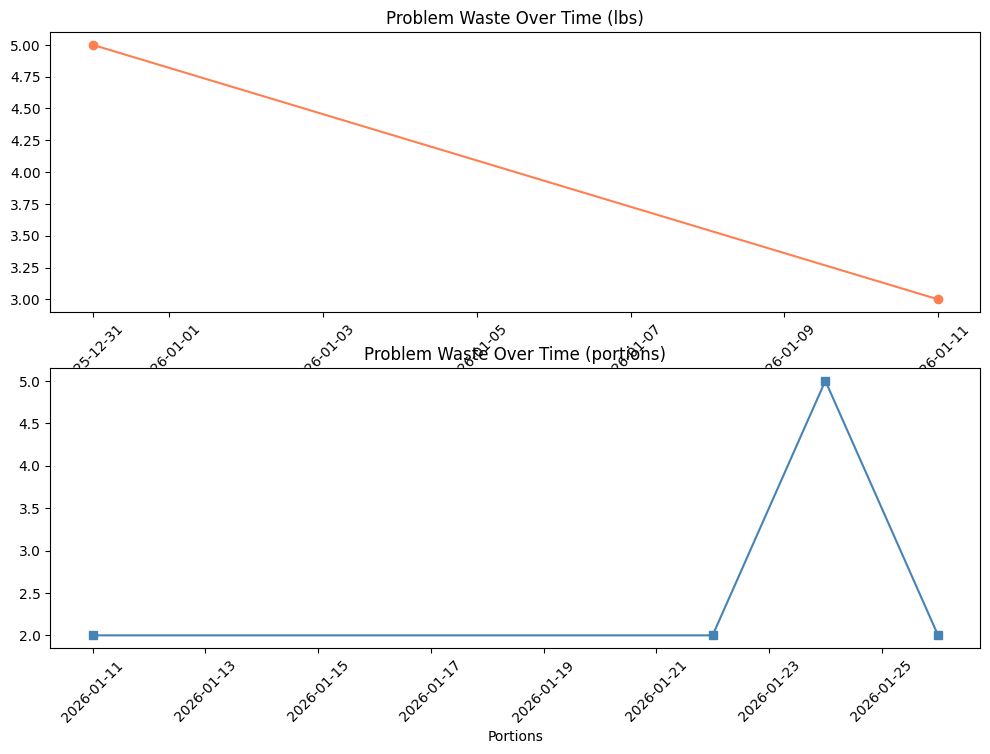

In [34]:
# Separate charts for each unity type
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Weight (lbs) over time
lbs_df = problem_df[problem_df['quantity_type'] == 'lbs'].copy()
lbs_df['date'] = pd.to_datetime(lbs_df['timestamp']).dt.date
if not lbs_df.empty:
    lbs_daily = lbs_df.groupby('date')['quantity_value'].sum()
    axes[0].plot(lbs_daily.index, lbs_daily.values, marker='o', color='coral')
    axes[0].set_title('Problem Waste Over Time (lbs)')
    axes[0].set_xlabel('Pounds')
    axes[0].tick_params(axis='x', rotation=45)

# Portions over time
po_df = problem_df[problem_df['quantity_type'] == 'po'].copy()
po_df['date'] = pd.to_datetime(po_df['timestamp']).dt.date
if not po_df.empty:
    po_daily = po_df.groupby('date')['quantity_value'].sum()
    axes[1].plot(po_daily.index, po_daily.values, marker='s', color='steelblue')
    axes[1].set_title('Problem Waste Over Time (portions)')
    axes[1].set_xlabel('Portions')
    axes[1].tick_params(axis='x', rotation=45)

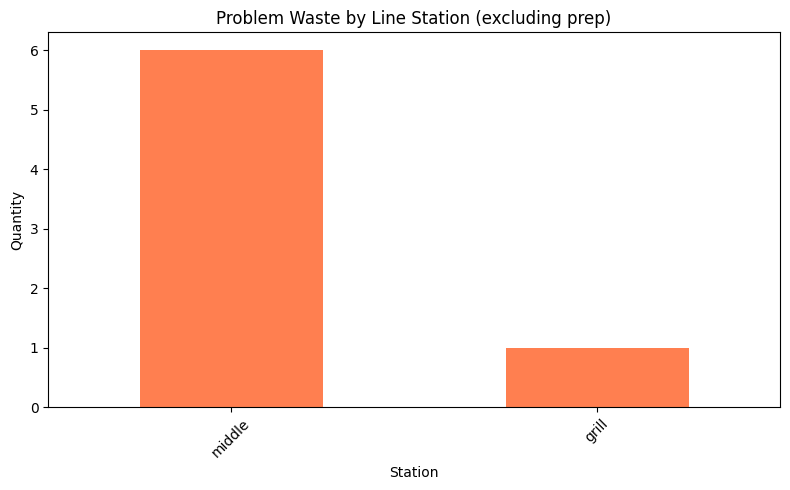

In [35]:
# Problem waste by line stations only (excluding prep stations)
line_stations = ['pasta', 'grill', 'middle', 'salumi']
line_problem = problem_df[problem_df['station'].isin(line_stations)]

station_waste = line_problem.groupby('station')['quantity_value'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
station_waste.plot(kind='bar', color='coral')
plt.title('Problem Waste by Line Station (excluding prep)')
plt.xlabel('Station')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

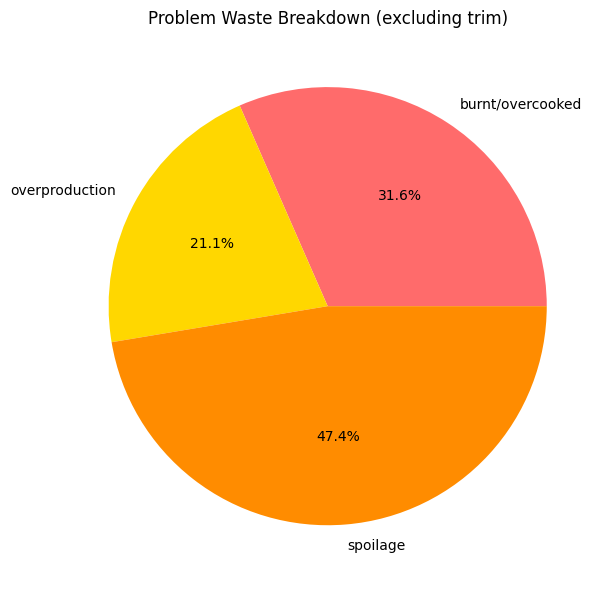

In [36]:
# Problem waste breakdown by type
problem_type_totals = problem_df.groupby('waste_type')['quantity_value'].sum()

plt.figure(figsize=(8, 6))
colors = ['#FF6B6B', '#FFD700', '#FF8C00']
plt.pie(problem_type_totals, labels=problem_type_totals.index, autopct='%1.1f%%', colors=colors)
plt.title('Problem Waste Breakdown (excluding trim)')
plt.tight_layout()
plt.show()

## Key Findings

1. **Trim is 80% of total waste** - Expected and budgeted. Focus should be on the remaining 20%.

2. **Spoilage is the biggest problem category (47%)** - Nearly half of problem waste. Batch timing and rotation are likely factors.

3. **Middle station leads in problem waste** - Among line stations, middle produces the most non-trim waste.

4. **Panna cotta and pork milanese are top problem items** - Both appear multiple times across different waste types.